In [1]:
%matplotlib inline

import warnings
import pickle as pkl
import itertools as it

import numpy as np
import matplotlib.pyplot as plt
import cv2
import gurobipy as gbp

warnings.simplefilter('ignore', np.RankWarning)

red = 76
white = 255
black = 0

In [24]:
class RouterAllocation(object):
    
    def __init__(self, instance, update_s=False):
        """
        Inicializa a classe, recebendo uma configuração de instancia.
        
        input: dict 
            like: 
            {
                'router_types': routers,
                'image': img,
                'scale': 10,
                'grid_size': 20,
                'client_min_sig': 10 ** (-60/20),
                'name': 'instancia0'
            }
        """
        self.update = update_s
        self.grid_size = instance['grid_size']
        self.img = instance['image']
        self.scale = instance['scale']
        self.size_x, self.size_y = instance['grid_size'] if isinstance(instance['grid_size'], tuple) else (instance['grid_size'], instance['grid_size'])
        self.grid_router  = list(zip(*np.where(self.img == red)))
        self.grid_clients = list(it.product(np.linspace(0, self.img.shape[0]-1, self.size_x, dtype=np.int), 
                                            np.linspace(0, self.img.shape[1]-1, self.size_y, dtype=np.int))
                                )
        self.Ak           = instance['client_min_sig'] * np.ones(len(self.grid_clients))
        self.routers      = instance['router_types']
        self.name         = instance['name']
        
        self.r_j = len(self.grid_router)
        self.r_k = len(self.grid_clients)
        self.r_i = len(self.routers.keys())
        self.compute_contributions()
        self.generate_model()
        print('Pronto pra rodar!')
    
    def signal_strength(self, xe, ye, xr, yr, router):
        # Contribuição da distancia entre os pontos
        d = np.linalg.norm([[xe - xr], [ye - yr]])
        distance_att = router['k'] / np.square(d / self.scale) if d else 1
        
        # Conta quantas paredes existem no caminho entre os pontos
        p = np.polyfit([xe, xr], [ye, yr], 1)
        x = np.linspace(xe, xr, np.abs(xe - xr) + 1, dtype=np.int)
        y = np.array(np.round(np.polyval(p, x)), dtype=np.int)
        walls = sum([self.img[i, j] == black for i, j in zip(x, y)])
        wall_att = 0.63087 ** walls if walls != 0 else 1
        return distance_att * wall_att
    
    def run(self):
        self.m.optimize()
        for v in self.m.getVars():
            if v.x: print(v.varName, v.x)
        print('Obj:', self.m.objVal)
        self.plot_solution()
    
    def compute_contributions(self):
        print('Calculando contribuição dos roteadores...')
        try:
            self.Sijk       = pkl.load(open("Sijk/Sijk_%s.p" % self.name, "rb"))
            self.AnalogSijk = pkl.load(open("Sijk/AnalogSijk_%s.p" % self.name, "rb"))
            assert not(self.update)
        except:
            self.AnalogSijk = np.array([[[self.signal_strength(xe, ye, xr, yr, router)
                                        for xr, yr in self.grid_clients] 
                                        for xe, ye in self.grid_router]
                                        for _, router in self.routers.items()])
            
            self.Sijk = np.array([[[1 if self.AnalogSijk[i, j, k] >= self.Ak[k] else 0  
                                    for k, (xr, yr) in enumerate(self.grid_clients)]
                                    for j, (xe, ye) in enumerate(self.grid_router)] 
                                    for i, router in self.routers.items()])
            
            pkl.dump(self.AnalogSijk, open("Sijk/AnalogSijk_%s.p" % self.name, "wb"))     
            pkl.dump(self.Sijk      , open("Sijk/Sijk_%s.p" % self.name, "wb"))     
        
    def plot_solution(self):
        
        Rij = np.array([v.x for v in self.m.getVars()]).reshape((self.r_i, self.r_j))
        
        x_m = int(np.round(self.img.shape[0] / self.scale))
        y_m = int(np.round(self.img.shape[1] / self.scale))
        
        client_points_x = len(np.unique([a[0] for a in self.grid_clients]))
        client_points_y = len(np.unique([a[1] for a in self.grid_clients]))
        
        
        potencia = np.array([np.sum([Rij[i, j] * self.AnalogSijk[i, j, k]
                                     for i in range(self.r_i)         
                                     for j in range(self.r_j)])
                                     for k in range(self.r_k)]).reshape(client_points_x, client_points_y)
        
        fig, ax = plt.subplots(figsize=(11, 10))
        c = ax.pcolor(20*np.log10(potencia))
        #fig.colorbar(c, ax=ax)
        x = np.array([a for a in np.where(self.img == black)[0]])
        y = np.array([a for a in np.where(self.img == black)[1]])
        
        ax.scatter((y / self.scale) * (self.grid_size / (self.img.shape[0] / self.scale) ), (x / self.scale) * (self.grid_size / (self.img.shape[0] / self.scale) ), c='k', marker='.')
        
        plt.yticks(np.arange(self.size_x + 1), [str(x) for x in np.linspace(0, y_m, self.size_x+1, dtype=np.int)])
        plt.xticks(np.arange(self.size_y + 1), [str(y) for y in np.linspace(0, x_m, self.size_y+1, dtype=np.int)])
        ax.set_title('Instancia %s' % self.name)
        ax.set_xlabel('Coordenada X (m)')
        ax.set_ylabel('Coordenada Y (m)');
    
    def generate_model(self):
        """
        Monta o modelo com os dados da instancia.

        """
        print('Gerando modelo...')
        self.m = gbp.Model("Alocação de roteadores")

        # variaveis
        Xij = np.array([
            [
                self.m.addVar(vtype=gbp.GRB.BINARY, name="X %d,%d" % (i, j)) 
                for j in range(self.r_j)
            ] 
            for i in range(self.r_i)
        ])

        # função objetivo
        Ci = [r['c'] for r in self.routers.values()]

        obj = gbp.LinExpr()
        for j in range(self.r_j): 
            for i in range(self.r_i): 
                obj += Ci[i] * Xij[i, j]
        self.m.setObjective(obj, gbp.GRB.MINIMIZE)

        ## restrições
        # maximo 1 roteador por ponto no grid
        for j in range(self.r_j):
            rest = gbp.LinExpr()
            for i in range(self.r_i): 
                rest += Xij[i, j]
            self.m.addConstr(rest <= 1, "r %d" % j)
        
        # sinal minimo
        for k in range(self.r_k): 
            rest = gbp.LinExpr()
            for i in range(self.r_i): 
                for j in range(self.r_j):
                    rest += Xij[i, j] * self.Sijk[i, j, k]
            self.m.addConstr(rest >= 1, "s %d" % k)

### Gerar instancias

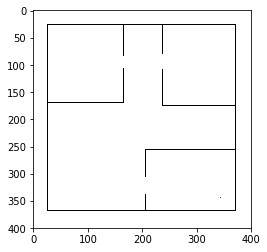

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 1612 rows, 72 columns and 110324 nonzeros
Model fingerprint: 0x6d877ae7
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 340.0000000
Presolve removed 1561 rows and 15 columns
Presolve time: 0.07s
Presolved: 51 rows, 57 columns, 1795 nonzeros
Found heuristic solution: objective 300.0000000
Variable types: 0 continuous, 57 integer (57 binary)

Root relaxation: objective 1.600000e+02, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  160.00000    0    3  300.00000  160.00000  46.7%     -    0s
H  

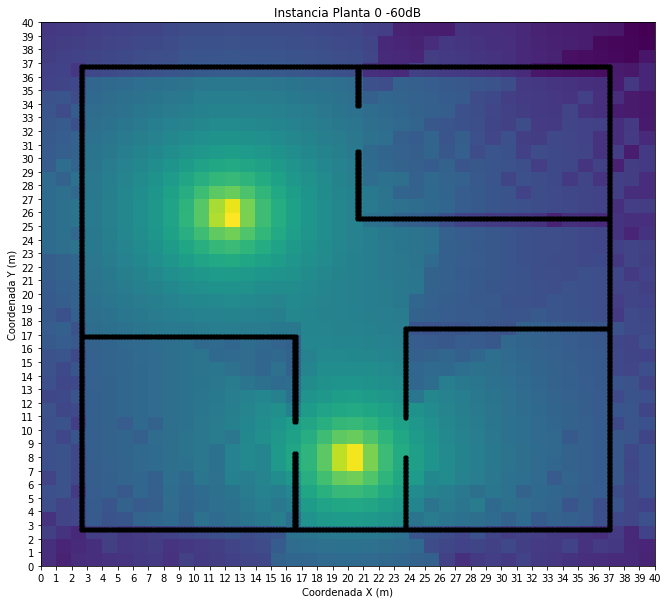

In [17]:
img = cv2.imread('instancias/instancia0.png', 0)
plt.imshow(img, cmap = 'gray')
plt.show()
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 120},
    2: {'k': 30, 'c': 140},
    3: {'k': 40, 'c': 160},
    4: {'k': 50, 'c': 170},
    5: {'k': 60, 'c': 200}
}

instancia0 = {
    'router_types': routers,
    'image': img,
    'scale': 10, # quantos pixels sao um metro
    'grid_size': 40,
    'client_min_sig': 10 ** (-60 / 20),
    'name': 'Planta 0 -60dB'
}

opt = RouterAllocation(instancia0)
opt.run()

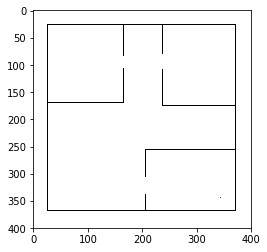

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 6412 rows, 72 columns and 340777 nonzeros
Model fingerprint: 0xc9ecdbbc
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 520.0000000
Presolve removed 6292 rows and 3 columns
Presolve time: 0.31s
Presolved: 120 rows, 69 columns, 4197 nonzeros
Variable types: 0 continuous, 69 integer (69 binary)

Root relaxation: objective 2.800000e+02, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     280.0000000  280.00000  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) in 0.36 s

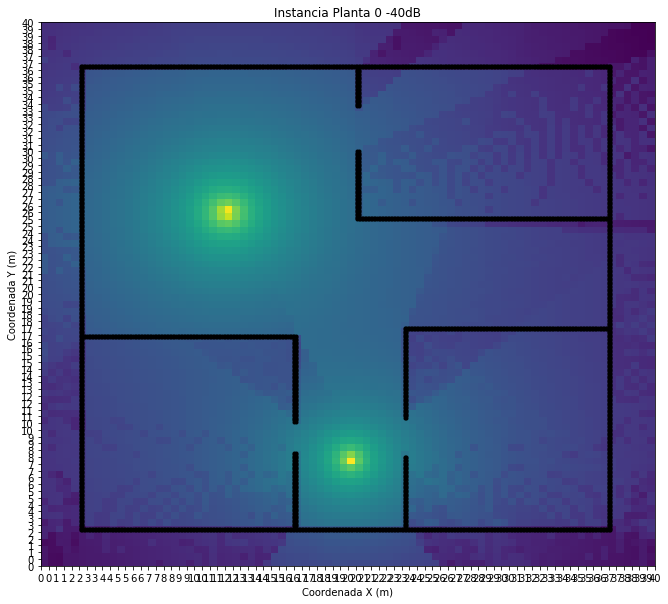

In [9]:
img = cv2.imread('instancias/instancia0.png', 0)
plt.imshow(img, cmap = 'gray')
plt.show()
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 120},
    2: {'k': 30, 'c': 140},
    3: {'k': 40, 'c': 160},
    4: {'k': 50, 'c': 170},
    5: {'k': 60, 'c': 200}
}

instancia1 = {
    'router_types': routers,
    'image': img,
    'scale': 10,
    'grid_size': 80,
    'client_min_sig': 10 ** (-40/20),
    'name': 'Planta 0 -40dB'
}

opt = RouterAllocation(instancia1)
opt.run()

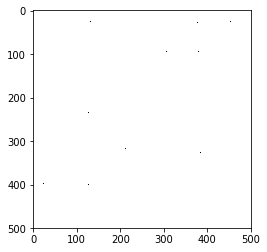

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 2543 rows, 258 columns and 188017 nonzeros
Model fingerprint: 0xd9ca600a
Variable types: 0 continuous, 258 integer (258 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1010.0000000
Sparsify removed 54742 nonzeros (83%)
Presolve added 0 rows and 250 columns
Presolve removed 1788 rows and 0 columns
Presolve time: 0.58s
Presolved: 755 rows, 508 columns, 10919 nonzeros
Variable types: 70 continuous, 438 integer (258 binary)

Root relaxation: objective 6.066667e+02, 230 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  606.66667    0  111 1010.0

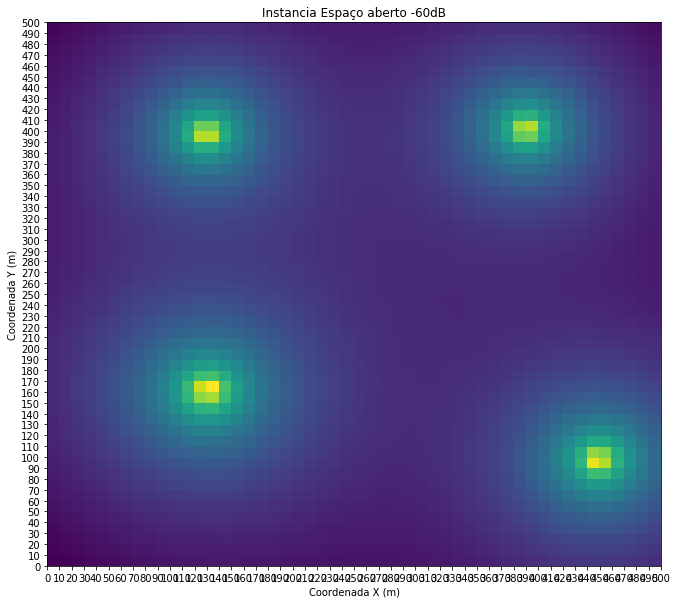

In [93]:
img = cv2.imread('instancias/instancia2.png', 0)
plt.imshow(img, cmap = 'gray')
plt.show()
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 120},
    2: {'k': 30, 'c': 140},
    3: {'k': 40, 'c': 160},
    4: {'k': 50, 'c': 170},
    5: {'k': 60, 'c': 200}
}

instancia2 = {
    'router_types': routers,
    'image': img,
    'scale': 1,
    'grid_size': 50,
    'client_min_sig': 10 ** (-60/20),
    'name': 'Espaço aberto -60dB'
}

opt = RouterAllocation(instancia2, update_s=True)
opt.run()

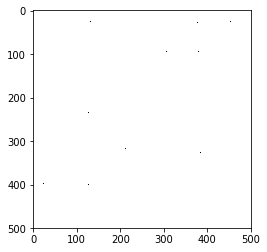

Calculando contribuição dos roteadores...
Gerando modelo...
Pronto pra rodar!
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 2543 rows, 258 columns and 25292 nonzeros
Model fingerprint: 0xc5e38d02
Variable types: 0 continuous, 258 integer (258 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6750.0000000
Presolve removed 2035 rows and 46 columns
Presolve time: 0.05s
Presolved: 508 rows, 212 columns, 4896 nonzeros
Found heuristic solution: objective 5980.0000000
Variable types: 0 continuous, 212 integer (212 binary)

Root relaxation: objective 5.050000e+03, 180 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    5050.0000000 5050.00000  0.00%     - 

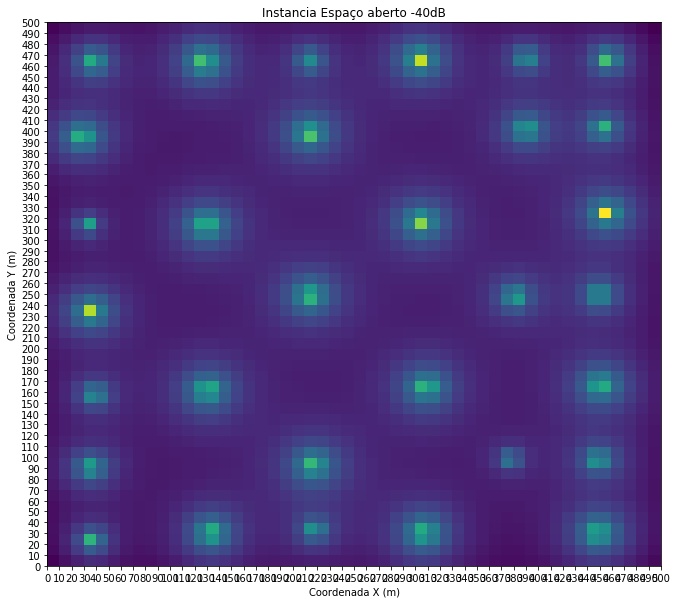

In [94]:
plt.imshow(img, cmap = 'gray')
plt.show()
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 120},
    2: {'k': 30, 'c': 140},
    3: {'k': 40, 'c': 160},
    4: {'k': 50, 'c': 170},
    5: {'k': 60, 'c': 200}
}

instancia3 = {
    'router_types': routers,
    'image': img,
    'scale': 1,
    'grid_size': 50,
    'client_min_sig': 10 ** (-40/20),
    'name': 'Espaço aberto -40dB'
}
opt = RouterAllocation(instancia3)
opt.run()

In [ ]:
def compute_k(Pt, Dt, f):
    lamb = 1 / f
    return Dt * Pt * lamb / (4 * np.pi)
    
routers = {
    0: {'Pt': 23, 'Dt': 3, 'f': 2.4e9 ,'c': 10809.00, 'name': 'Cisco Aironet'     },
    1: {'Pt': 20, 'Dt': 3, 'f': 2.4e9 ,'c': 91.73   , 'name': 'TP-Link TL-WR741ND'},
    1: {'Pt': 20, 'Dt': 3, 'f': 2.4e9 ,'c': 106.00  , 'name': 'TP-Link TL-WR94ON' },
    2: {'Pt': 20, 'Dt': 3, 'f': 2.4e9 ,'c': 216.00  , 'name': 'TP-Link AC1350'    }
}

for router in routers.values():
    K = compute_k(router['Pt'], router['Dt'],  router['f'])
    print("Router: {}  K: {}".format(router['name'],  K))